In [1]:
import math, random

In [2]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                print(child)
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [262]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

            
            

In [263]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

m = L.tanh(); m.label = 'm'

Value(data=-8.0)
Value(data=4.0)
Value(data=10.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)
Value(data=-2.0)


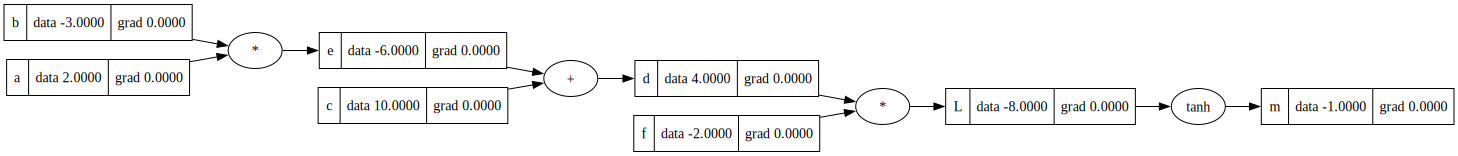

In [260]:
draw_dot(m)

### Basic neuron
![bacic_neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

In [9]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(1,-1)) for _ in range(nin)]
        self.b = Value(random.uniform(1,-1))
        
    def __call__(self,x):
        # Apply the transformation to x i.e w * x + b
        out =  sum([w*x for w,x in zip(self.w, x)], self.b)
        out = out.tanh()
        return out


### Multilayer perceptron (MLP)

![mlp](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

#### MLP

In [261]:

            
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [152]:
n = Neuron(3)

In [153]:
n.parameters()

[Value(data=-0.433891264597267),
 Value(data=-0.7415071176949894),
 Value(data=0.25672676093266356),
 Value(data=-0.5779502945189039)]

In [154]:
l = Layer(3,4)

In [155]:
l.parameters()

[Value(data=0.7715282289599554),
 Value(data=0.786622932305437),
 Value(data=-0.5469872594559122),
 Value(data=-0.3301941693668824),
 Value(data=0.9884695759631099),
 Value(data=-0.24508760182393763),
 Value(data=-0.4536178957047019),
 Value(data=0.29968254951290585),
 Value(data=0.3194587852515256),
 Value(data=-0.8172333248360464),
 Value(data=0.10247135818093733),
 Value(data=0.4317725577622604),
 Value(data=0.1216806021310497),
 Value(data=0.7489148091536537),
 Value(data=-0.2472778490566383),
 Value(data=-0.5056834246696558)]

In [156]:
n([1.0,2.0, 3.0])

Value(data=-0.9384235617594683)

In [213]:
mlp = MLP(3, [4,4,1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, 5.0, -2.0],
    [-3.0, 4.0, -1.0],
    [4.0, 2.0, -2.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [249]:
loss.backward()

In [253]:
learning_rate = 0.01

for p in mlp.parameters():
    p.data += -learning_rate* p.grad
    


In [254]:
# forward pass
ypred = [mlp(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.8651295747489756)

#### Gradient Descent

In [264]:
for _ in range(5*20):
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    
        
    for p in mlp.parameters():
        p.grad = 0

    loss.backward()
    
    for p in mlp.parameters():
        p.data += -learning_rate* p.grad
    
    print(loss)
        
    

Value(data=0.07689175938718561)
Value(data=0.07612468817462772)
Value(data=0.07537101520642442)
Value(data=0.07463041259628173)
Value(data=0.07390256271094085)
Value(data=0.07318715777986216)
Value(data=0.07248389952250589)
Value(data=0.07179249879228758)
Value(data=0.07111267523633572)
Value(data=0.0704441569702387)
Value(data=0.06978668026701128)
Value(data=0.06913998925955754)
Value(data=0.06850383565595225)
Value(data=0.06787797846689606)
Value(data=0.06726218374474516)
Value(data=0.06665622433354086)
Value(data=0.06605987962950519)
Value(data=0.06547293535149323)
Value(data=0.06489518332092367)
Value(data=0.06432642125073401)
Value(data=0.06376645254293405)
Value(data=0.06321508609435057)
Value(data=0.06267213611018134)
Value(data=0.06213742192499665)
Value(data=0.06161076783084236)
Value(data=0.06109200291212306)
Value(data=0.06058096088695154)
Value(data=0.0600774799546794)
Value(data=0.05958140264932426)
Value(data=0.05909257569863502)
Value(data=0.058610849888543634)
Value(dat

In [257]:
for x in xs:
    print(mlp(x))

Value(data=0.8210835018580535)
Value(data=-0.7962180230386738)
Value(data=-0.9998716864641167)
Value(data=0.94209028163444)


## Lets train decision boundary classifier

In [392]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

In [393]:
y = y*2 - 1
y

array([ 1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1,
        1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,
       -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1])

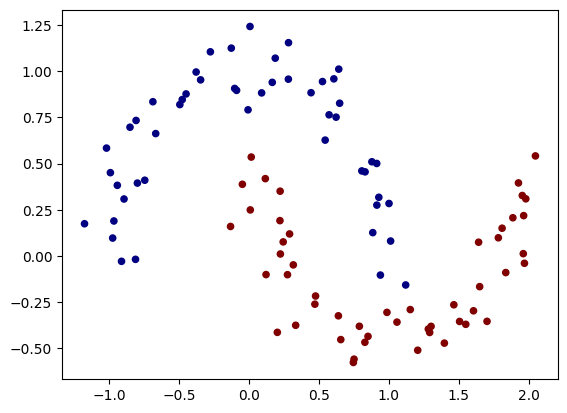

In [341]:
plt.scatter(X[:,0], X[:,1],c=y, s=20, cmap='jet')
plt.show()

In [291]:
mlp = MLP(2, [32,32,1])

In [292]:
learning_rate = 0.001

In [293]:
for _ in range(100):
    ypred = [mlp(x) for x in X]
    loss = sum((yout - y_true)**2 for yout, y_true in zip(ypred, y))
    
    for p in mlp.parameters():
        p.grad = 0
        
    loss.backward()
    
    for p in mlp.parameters():
        p.data += -learning_rate*p.grad
        
    print(loss)

Value(data=182.1622463231299)
Value(data=65.05133379917447)
Value(data=61.26581110246475)
Value(data=55.79599721490805)
Value(data=51.77747973059866)
Value(data=47.65322613718348)
Value(data=43.88060919117072)
Value(data=40.52506065613967)
Value(data=37.49252562016227)
Value(data=34.43070937614673)
Value(data=30.623122657211468)
Value(data=24.738047064899384)
Value(data=17.050869336505848)
Value(data=13.784637992900473)
Value(data=11.659200266390469)
Value(data=10.178400557836552)
Value(data=9.184089771281702)
Value(data=8.48046441876675)
Value(data=7.928629246802346)
Value(data=7.532672632357527)
Value(data=7.032821896013472)
Value(data=6.65621110168662)
Value(data=6.168347199548206)
Value(data=5.808679025852884)
Value(data=5.462207622996187)
Value(data=5.201366412273588)
Value(data=4.98009704551094)
Value(data=4.795857417554366)
Value(data=4.633842265216165)
Value(data=4.488230079494224)
Value(data=4.354989401169345)
Value(data=4.231942657391976)
Value(data=4.117657374592167)
Value(d

In [296]:
# Define grid range
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Create grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

In [302]:
xx.ravel()

array([-2.0841472, -2.0741472, -2.0641472, ...,  2.9858528,  2.9958528,
        3.0058528], shape=(188700,))

### Lets separate the decision boundary for these data using our trained model

In [343]:
X, y = make_moons(n_samples=100, noise=0.1)

In [368]:
x1 = np.arange(X[:,0].min() - 1, X[:, 0].max() + 1, 0.25)

x2 = np.arange(X[:,1].min() - 1, X[:, 1].max() + 1, 0.25)

xx, yy = np.meshgrid(x1,x2)

# Combined data points
Xmesh = np.c_[xx.ravel(),yy.ravel()]


In [380]:
inputs = [list(map(Value, xrow)) for xrow in Xmesh ]
scores = list(map(mlp, inputs))


In [382]:
Z = np.array([s.data > 0 for s in scores])

In [384]:
Z = Z.reshape(xx.shape)

In [385]:
Z.shape

(16, 21)

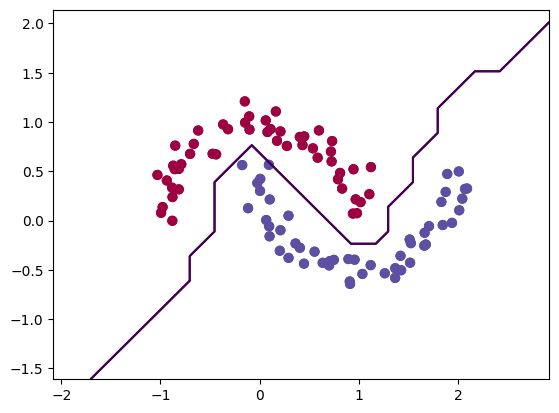

In [400]:
plt.contour(xx,yy, Z)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

